**Topics:**
* Remove images correupted by bone artifacts.
* Tumor outlier inspection.
* Inspect GL stats.
* 

REF: *Practical guidelines for handling head and neck computed tomography artifacts for quantitative image analysis*:
* Most features were robust with up to 50% of the original GTV removed.
* Conclude that removing slices affected by streak artifacts can enable these scans to be included in radiomics studies. 
* Contours of structures can abut bone without being affected by beam hardening if needed.

In [1]:
import sys
sys.path.append('./')

import os
import re
import nrrd

#import networkx as nx

from _backend import ioutil
from pathlib import Path


import numpy as np
import pandas as pd

from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy

#from skimage.measure import compare_ssim as ssim

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
#!pip install scikit-image -U

In [3]:
patient_id = np.load('./../../../data_source/patient_id.npy')

In [4]:
# Global CT max: 4094.95

paths_to_ct = ioutil.relative_paths('./../../../data_source/images/ct_nrrd', target_format='nrrd')
paths_to_pet = ioutil.relative_paths('./../../../data_source/images/pet_nrrd', target_format='nrrd')
paths_to_mask = ioutil.relative_paths('./../../../data_source/images/masks_nrrd', target_format='nrrd')
ct, pet, mask = {}, {}, {}
ct_cropped, pet_cropped = {}, {} 
for num, path_to_ct in enumerate(paths_to_ct):
    
    ct_image, _ = nrrd.read(path_to_ct)
    ct[path_to_ct] = ct_image

    pet_image, _ = nrrd.read(paths_to_pet[num])
    pet[paths_to_pet[num]] = pet_image
    
    mask_image, _ = nrrd.read(paths_to_mask[num])
    mask[paths_to_mask[num]] = mask_image
    
    ct_cropped[path_to_ct] = ct[path_to_ct] * mask_image

    pet_cropped[paths_to_pet[num]] = pet[paths_to_pet[num]] * mask_image

In [5]:
#list(ct_cropped.keys())

# Manual outlier detection

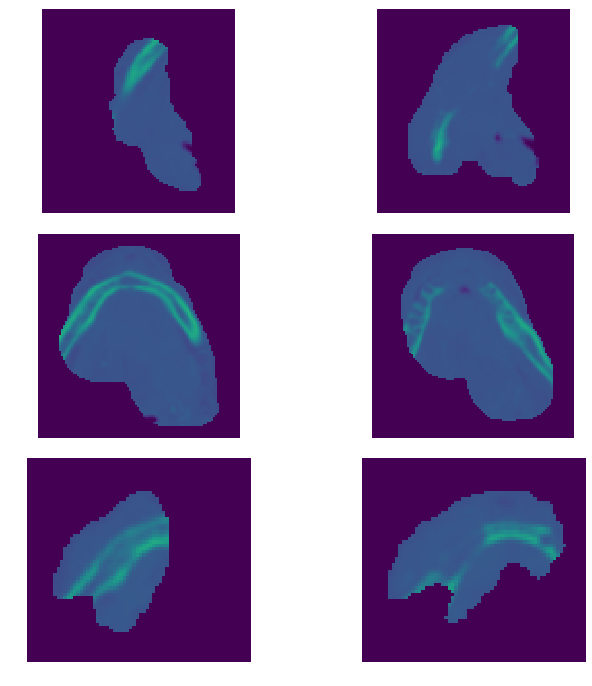

In [6]:
# Tumor regions from patients removed from the data set. Images were manually inspected prior to analysis. 
# Three CT volumes were determined to contain too many artifacts to be included in the analysis, and were, 
# thus, removed from the data.
images_to_drop = [
    ct_cropped['./../../../data_source/images/ct_nrrd/P082CT.nrrd'][20:-20, 20:-10, 40],
    ct_cropped['./../../../data_source/images/ct_nrrd/P082CT.nrrd'][20:-20, 20:-10, 50],
    ct_cropped['./../../../data_source/images/ct_nrrd/P038CT.nrrd'][15:-15, 10:-10, 60],
    ct_cropped['./../../../data_source/images/ct_nrrd/P038CT.nrrd'][15:-15, 10:-10, 70],
    ct_cropped['./../../../data_source/images/ct_nrrd/P045CT.nrrd'][10:-15, 15:-20, 30],
    ct_cropped['./../../../data_source/images/ct_nrrd/P045CT.nrrd'][10:-15, 15:-20, 35],
]
# TODO: Avoid subplots and plot slices on common background.
cmap = ListedColormap(sns.cubehelix_palette(400, start=2, rot=0, dark=0, light=1, reverse=False))
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for num, axis in enumerate(axes.ravel()):
    # NOTE: Resize images to tumor volume region.
    axis.imshow(
        images_to_drop[num], 
        #cmap=plt.cm.gray,
        #vmin=np.min(images_to_drop[num]), 
        #vmax=np.max(images_to_drop[num]),
        vmin=0,
        vmax=2**12,
    )
    axis.axis('off')
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig(
    './../../../figures/dropped_samples.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Determining threshold for removing slices affected by streak artifacts.

In [7]:
def threshold(image, thresh=1400):
    
    _image = np.copy(image)
    _image[image >= thresh] = 0
    
    return _image

In [8]:
# NOTE: 
# * Use original mask to compute shape features.
# * Use reduced stacks to compute texture and firstorder features.
# * Apply windowing to images where > 40% (or 50%) of slices were removed. 

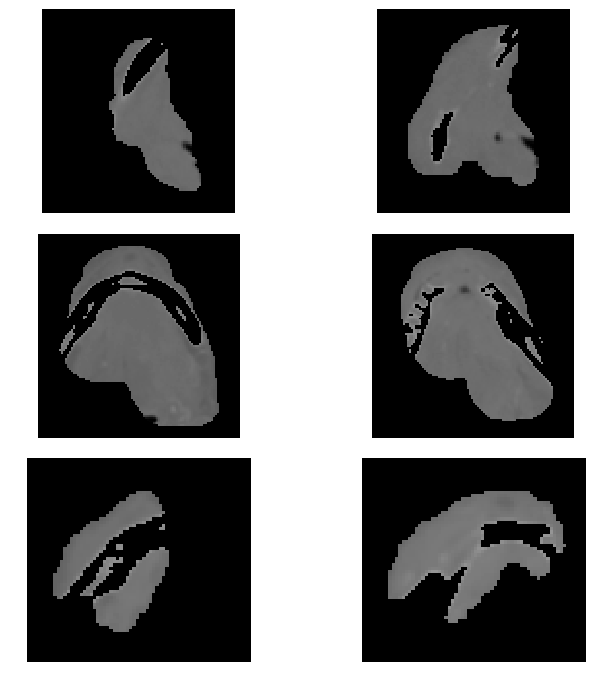

In [9]:
# Empirically defined threshold based on images containing bone artifacts.
images_to_drop = [
    ct_cropped['./../../../data_source/images/ct_nrrd/P082CT.nrrd'][20:-20, 20:-10, 40],
    ct_cropped['./../../../data_source/images/ct_nrrd/P082CT.nrrd'][20:-20, 20:-10, 50],
    ct_cropped['./../../../data_source/images/ct_nrrd/P038CT.nrrd'][15:-15, 10:-10, 60],
    ct_cropped['./../../../data_source/images/ct_nrrd/P038CT.nrrd'][15:-15, 10:-10, 70],
    ct_cropped['./../../../data_source/images/ct_nrrd/P045CT.nrrd'][10:-15, 15:-20, 30],
    ct_cropped['./../../../data_source/images/ct_nrrd/P045CT.nrrd'][10:-15, 15:-20, 35],
]
cmap = ListedColormap(sns.cubehelix_palette(400, start=2, rot=0, dark=0, light=1, reverse=False))
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for num, axis in enumerate(axes.ravel()):
    # NOTE: Resize images to tumor volume region.
    axis.imshow(
        threshold(images_to_drop[num]),
        #images_to_drop[num],
        cmap=plt.cm.gray,
        vmin=np.min(images_to_drop[num]), 
        vmax=np.max(images_to_drop[num])
    )
    axis.axis('off')
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig(
    './../../../figures/dropped_samples.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

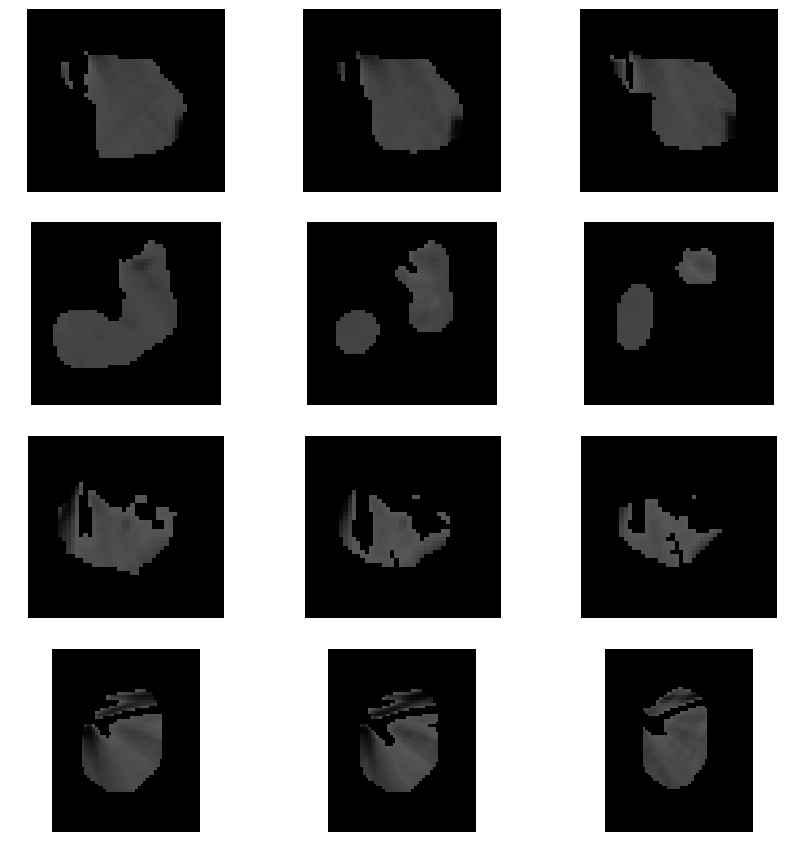

In [10]:
# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
# Selected slices from the four patients with max(I) > 3000.
images_to_plot = [
    ct_cropped['./../../../data_source/images/ct_nrrd/P049CT.nrrd'][15:-15, 20:-10, 49],
    ct_cropped['./../../../data_source/images/ct_nrrd/P049CT.nrrd'][15:-15, 20:-10, 50],
    ct_cropped['./../../../data_source/images/ct_nrrd/P049CT.nrrd'][15:-15, 20:-10, 52],
    
    ct_cropped['./../../../data_source/images/ct_nrrd/P100CT.nrrd'][15:-20, 15:-10, 42],
    ct_cropped['./../../../data_source/images/ct_nrrd/P100CT.nrrd'][15:-20, 15:-10, 47],
    ct_cropped['./../../../data_source/images/ct_nrrd/P100CT.nrrd'][15:-20, 15:-10, 50],
    
    ct_cropped['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][15:-15, 15:-10, 47],
    ct_cropped['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][15:-15, 15:-10, 48],
    ct_cropped['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][15:-15, 15:-10, 50],
    
    ct_cropped['./../../../data_source/images/ct_nrrd/P164CT.nrrd'][15:-15, 15:-10, 58],
    ct_cropped['./../../../data_source/images/ct_nrrd/P164CT.nrrd'][15:-15, 15:-10, 59],
    ct_cropped['./../../../data_source/images/ct_nrrd/P164CT.nrrd'][15:-15, 15:-10, 61],
]
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
for num, axis in enumerate(axes.ravel()):
    # Resize images to tumor volume region.
    axis.imshow(
        threshold(images_to_plot[num]),
        #images_to_plot[num],
        cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12,
    )
    vmin=np.min(images_to_plot[num]),
    vmax=np.max(images_to_plot[num])
    axis.axis('off')   
#plt.subplots_adjust(wspace=0, hspace=0.2)
plt.tight_layout()

In [11]:
# NOTE: Thresholding causes artifact origins to disappear, as well as large parts of the tumor influenced
# by streaking artifacts.
"""

# NB: Must modify masks accordingly when using bone thresholded CT images 
# in feature extraction.

# Include only bone thresholded CT images.
for num, ct_image in enumerate(ct.values()):
    # Replace CT images with thresholded.
    ct[paths_to_ct[num]] = bone_threshold(ct_image)
    ct_cropped[paths_to_ct[num]] = bone_threshold(ct_cropped[paths_to_ct[num]])
    
    # Remove voxels from masks corresponding to thresholded CT regions.
    _mask = np.copy(mask[paths_to_mask[num]])
    _mask[np.where(ct_cropped[paths_to_ct[num]] == 0)] = 0
    mask[paths_to_mask[num]] = _mask
"""

'\n\n# NB: Must modify masks accordingly when using bone thresholded CT images \n# in feature extraction.\n\n# Include only bone thresholded CT images.\nfor num, ct_image in enumerate(ct.values()):\n    # Replace CT images with thresholded.\n    ct[paths_to_ct[num]] = bone_threshold(ct_image)\n    ct_cropped[paths_to_ct[num]] = bone_threshold(ct_cropped[paths_to_ct[num]])\n    \n    # Remove voxels from masks corresponding to thresholded CT regions.\n    _mask = np.copy(mask[paths_to_mask[num]])\n    _mask[np.where(ct_cropped[paths_to_ct[num]] == 0)] = 0\n    mask[paths_to_mask[num]] = _mask\n'

In [12]:
def crop_to_tumor_volume(image):

    coords = np.argwhere(image)
    x_min, y_min, z_min = coords.min(axis=0)
    x_max, y_max, z_max = coords.max(axis=0)

    return image[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]

# Remove manually identified corrupted images

In [13]:
# Patient IDs to skip in analysis.
DROPPED = [38, 45, 82]

old_size = np.size(patient_id)
patient_id = np.array([p_id for p_id in patient_id if p_id not in DROPPED])
new_size = np.size(patient_id)

assert old_size == new_size + len(DROPPED)

In [14]:
# Drop outliers from data to inspect.
paths_to_drop = [
    './../../../data_source/images/ct_nrrd/P038CT.nrrd',
    './../../../data_source/images/ct_nrrd/P045CT.nrrd',
    './../../../data_source/images/ct_nrrd/P082CT.nrrd'
]
ct_ad, pet_ad = {}, {}
ct_cropped_ad, pet_cropped_ad = {}, {} 
for num, path_to_ct in enumerate(paths_to_ct):
    
    if path_to_ct in paths_to_drop:
        pass
    else:
        ct_ad[path_to_ct] = ct[path_to_ct]
        pet_ad[paths_to_pet[num]] = pet[paths_to_pet[num]]

        ct_cropped_ad[path_to_ct] = ct_cropped[path_to_ct]
        pet_cropped_ad[paths_to_pet[num]] = pet_cropped[paths_to_pet[num]]
        
assert len(ct_ad.keys()) == np.size(patient_id) 
assert len(pet_ad.keys()) == np.size(patient_id) 
assert len(ct_cropped_ad.keys()) == np.size(patient_id) 
assert len(pet_cropped_ad.keys()) == np.size(patient_id) 

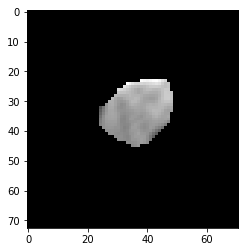

In [29]:
I = ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 50]

plt.figure()
plt.imshow(I, cmap=plt.cm.gray)

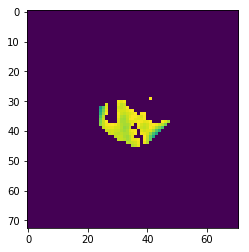

In [32]:
_I = np.copy(I)
_I[I > 1400] = 0
plt.figure()
plt.imshow(_I)

[]

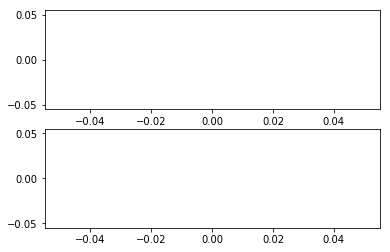

In [19]:


fig, axes = plt.subplots(nrows=2)
axes[0].plot()
axes[1].plot()

# Tumor outlier inspection

In [20]:
def calc_image_statistics(image):
    
    return {
        'gl_mean': np.mean(image),
        'gl_median': np.median(image),
        'gl_min': np.min(image),
        'gl_max': np.max(image)
    }

In [21]:
# Statistics on complete (not cropped) images.
ct_ad_stats, pet_ad_stats = {}, {}
for num, (pet_image, ct_image) in enumerate(zip(pet_ad.values(), ct_ad.values())):
    
    pet_ad_stats[num] = calc_image_statistics(pet_image)
    ct_ad_stats[num] = calc_image_statistics(ct_image)

# Sanity check: Adjusting to Python counting logic.
assert num == np.size(patient_id) - 1
 
# Statistics on tumor (cropped) images.
ct_cropped_ad_stats, pet_cropped_ad_stats = {}, {}
for num, (pet_image, ct_image) in enumerate(zip(pet_cropped_ad.values(), ct_cropped_ad.values())):
    
    pet_cropped_ad_stats[num] = calc_image_statistics(pet_image)
    ct_cropped_ad_stats[num] = calc_image_statistics(ct_image)

# Sanity check: Adjusting to Python counting logic.
assert num == np.size(patient_id) - 1

df_ct_ad_stats = pd.DataFrame(ct_ad_stats)
df_ct_cropped_ad_stats = pd.DataFrame(ct_cropped_ad_stats)

df_pet_ad_stats = pd.DataFrame(pet_ad_stats)
df_pet_cropped_ad_stats = pd.DataFrame(pet_cropped_ad_stats)

df_ct_ad_stats.columns = patient_id
df_ct_cropped_ad_stats.columns = patient_id

df_pet_ad_stats.columns = patient_id
df_pet_cropped_ad_stats.columns = patient_id

In [22]:
ct_cropped_std = []
for ct_image in ct_cropped_ad.values():
    ct_cropped_std.append(np.std(ct_image))
    
ct_cropped_std = np.array(ct_cropped_std)

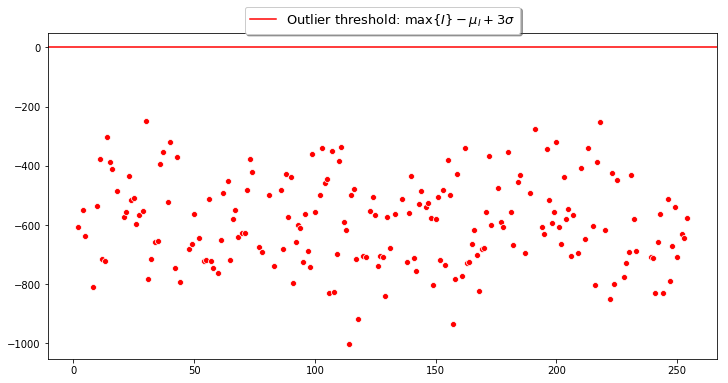

In [23]:
# Outlier detection: 
# * Any value > 0 indicates the voxel is greater than the corresponding outlier threshold, and is thus a 
#   potential outlier.
# * Outliers may be caused by artifacts, which means a potential reduction in outliers due to artifact processing.
# * Min CT and PET values = 0, thus no need to consider small outliers.

n = 3

df_ct_cropped_ad_max = df_pet_ad_stats.loc['gl_max', :].values
outliers = np.mean(df_ct_cropped_ad_max) + n * ct_cropped_std
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=np.squeeze(df_pet_ad_stats.columns.values), 
    y=np.squeeze(df_ct_cropped_ad_max) - outliers,
)
plt.axhline(y=0)
plt.legend(
    [r'Outlier threshold: $\max \left \{ I \right \} - \mu_{I} + 3 \sigma$'],
    title_fontsize=14,
    fontsize=13,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.1),
    ncol=1, 
    fancybox=True, 
    shadow=True
)

# CT Image & Tumor Graylevel Statistics

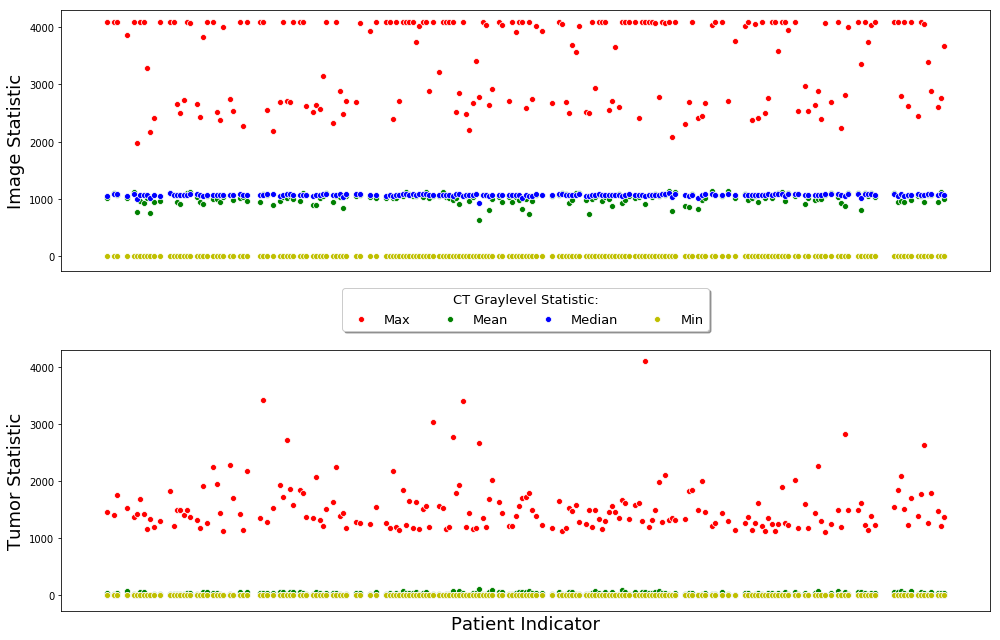

In [24]:
# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.

from matplotlib import rcParams, cycler

rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])

# Plot CT image and tumor GL stats. 

# Observations: 
# * The difference between average max in the complete and cropped image illustrates the significant amount of 
#   artifacts in each image. 

fig, (image_axis, cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Max', 'Mean', 'Median', 'Min']
for num, (ct_cropped_row_label, ct_row_label) in enumerate(zip(df_ct_cropped_ad_stats.T, df_ct_ad_stats.T)):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_ct_ad_stats.columns.values), 
        y=np.squeeze(df_ct_ad_stats.loc[ct_row_label, :].values),
        ax=image_axis,
    )
    # Plot tupr stats.
    sns.scatterplot(
        x=np.squeeze(df_ct_cropped_ad_stats.columns.values), 
        y=np.squeeze(df_ct_cropped_ad_stats.loc[ct_cropped_row_label, :].values),
        ax=cropped_axis,
        label=labels[num]
    )
cropped_axis.legend(
    title='CT Graylevel Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
image_axis.set_ylabel('Image Statistic', fontsize=18)
cropped_axis.set_ylabel('Tumor Statistic', fontsize=18)
plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './../../../figures/ct_gl_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

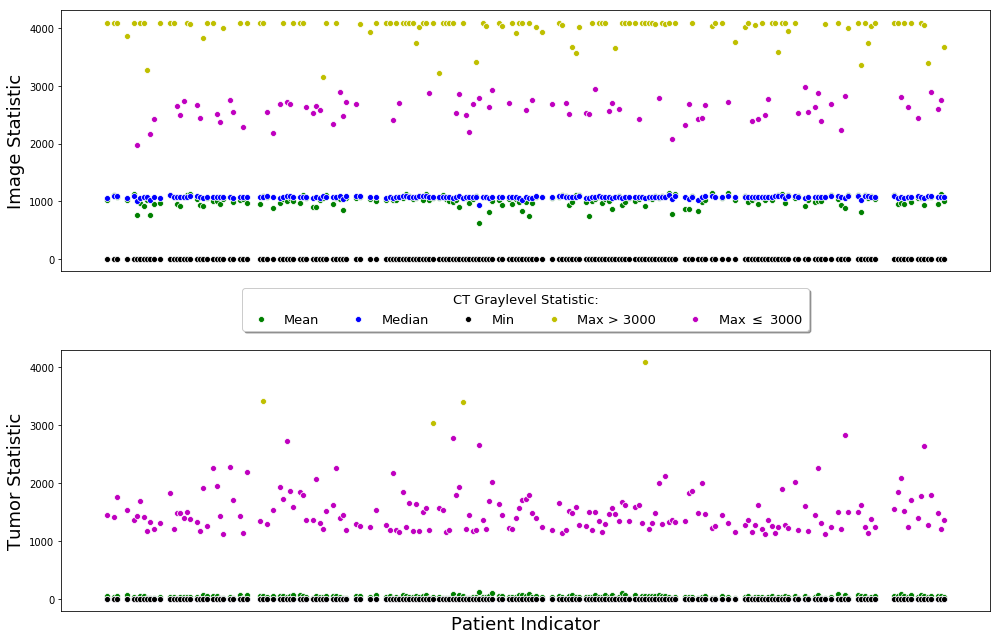

In [25]:
# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
rcParams['axes.prop_cycle'] = cycler(color=['g', 'b', 'k', 'y', 'm'])

thresh = 3000

# HACK:
_tmp = df_ct_ad_stats.copy()
_tmp.loc['greater', :] = None
_tmp.loc['less', :] = None
less_idx = df_ct_ad_stats.loc['gl_max', :] < thresh
greater_idx = df_ct_ad_stats.loc['gl_max', :] >= thresh
_tmp.loc['less', less_idx] = df_ct_ad_stats.loc['gl_max', less_idx]
_tmp.loc['greater', greater_idx] = df_ct_ad_stats.loc['gl_max', greater_idx]
_tmp.drop('gl_max', inplace=True)

_tmp_cropped = df_ct_cropped_ad_stats.copy()
_tmp_cropped.loc['greater', :] = None
_tmp_cropped.loc['less', :] = None
cropped_less_idx = df_ct_cropped_ad_stats.loc['gl_max', :] < thresh
cropped_greater_idx = df_ct_cropped_ad_stats.loc['gl_max', :] >= thresh
_tmp_cropped.loc['less', cropped_less_idx] = df_ct_cropped_ad_stats.loc['gl_max', cropped_less_idx]
_tmp_cropped.loc['greater', cropped_greater_idx] = df_ct_cropped_ad_stats.loc['gl_max', cropped_greater_idx]
_tmp_cropped.drop('gl_max', inplace=True)

fig, (image_axis, cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Mean', 'Median', 'Min', r'Max > 3000', r'Max $\leq$ 3000']
for num, (ct_cropped_row_label, ct_row_label) in enumerate(zip(_tmp_cropped.T, _tmp.T)):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(_tmp.columns.values), 
        y=np.squeeze(_tmp.loc[ct_row_label, :].values),
        ax=image_axis,
    )
    # Plot tupr stats.
    sns.scatterplot(
        x=np.squeeze(_tmp_cropped.columns.values), 
        y=np.squeeze(_tmp_cropped.loc[ct_cropped_row_label, :].values),
        ax=cropped_axis,
        label=labels[num]
    )
cropped_axis.legend(
    title='CT Graylevel Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=5, 
    fancybox=True, 
    shadow=True
)
image_axis.set_ylabel('Image Statistic', fontsize=18)
cropped_axis.set_ylabel('Tumor Statistic', fontsize=18)
plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './../../../figures/ct_gl_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Inspecting images in max > 3000 group

In [26]:
# 49, 100, 109, 164
_tmp_cropped.loc['greater'].dropna()

49     3413.780957
100    3038.741817
109    3395.597620
164    4094.937514
Name: greater, dtype: float64

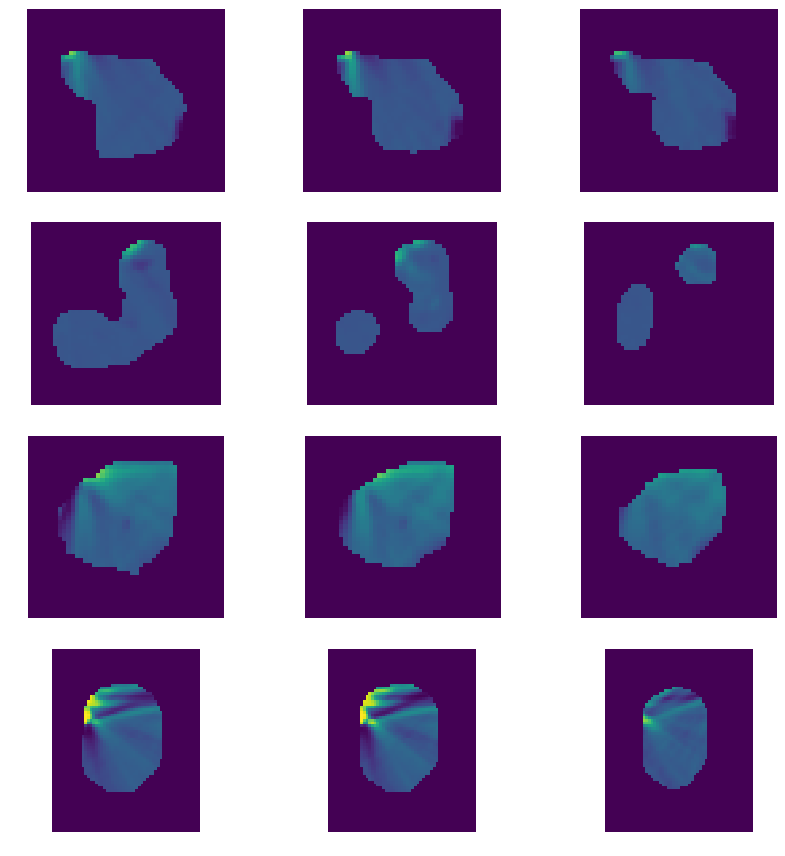

In [27]:
# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
# Selected slices from the four patients with max(I) > 3000.
images_to_plot = [
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P049CT.nrrd'][15:-15, 20:-10, 49],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P049CT.nrrd'][15:-15, 20:-10, 50],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P049CT.nrrd'][15:-15, 20:-10, 52],
    
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P100CT.nrrd'][15:-20, 15:-10, 42],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P100CT.nrrd'][15:-20, 15:-10, 47],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P100CT.nrrd'][15:-20, 15:-10, 50],
    
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][15:-15, 15:-10, 47],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][15:-15, 15:-10, 48],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][15:-15, 15:-10, 50],
    
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P164CT.nrrd'][15:-15, 15:-10, 58],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P164CT.nrrd'][15:-15, 15:-10, 59],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P164CT.nrrd'][15:-15, 15:-10, 61],
]
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
for num, axis in enumerate(axes.ravel()):
    # Resize images to tumor volume region.
    axis.imshow(
        images_to_plot[num], 
        #cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12,
    )
    vmin=np.min(images_to_plot[num]),
    vmax=np.max(images_to_plot[num])
    axis.axis('off')   
#plt.subplots_adjust(wspace=0, hspace=0.2)
plt.tight_layout()

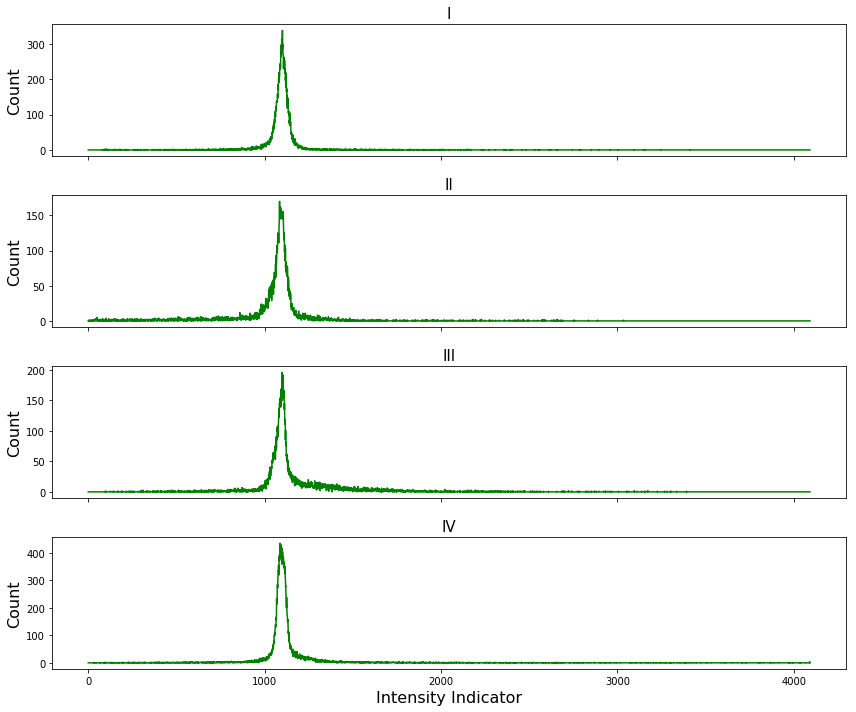

In [28]:
# Observations:
# * Histogram resembles dirac delta function (for not so small a param, see wiki).

# NOTE: Use dirac delta as histogram estimator in imputing pixels affected by streak artifacts?

imgs = [
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P049CT.nrrd'],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P100CT.nrrd'],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P164CT.nrrd'],
]
# Try bins: 32, 64, 128 as in feature extraction.
fig, axes = plt.subplots(nrows=len(imgs), figsize=(12, 10), sharex=True)
titles = ['I', 'II', 'III', 'IV']
for num, axis in enumerate(axes.ravel()):
    hist, _ = np.histogram(np.squeeze(imgs[num].ravel()), bins=np.linspace(0, 2**12, 2**12))
    # NOTE: Skip background voxels.
    hist = hist[1:]
    axes[num].set_title(titles[num], fontsize=15)
    axes[num].plot(np.arange(np.size(hist)), np.squeeze(hist))
    axes[num].set_ylabel('Count', fontsize=16)
    
plt.xlabel('Intensity Indicator', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Inspecting images in max $\leq$ 3000 group

In [29]:
# Not among 49, 100, 109, 164

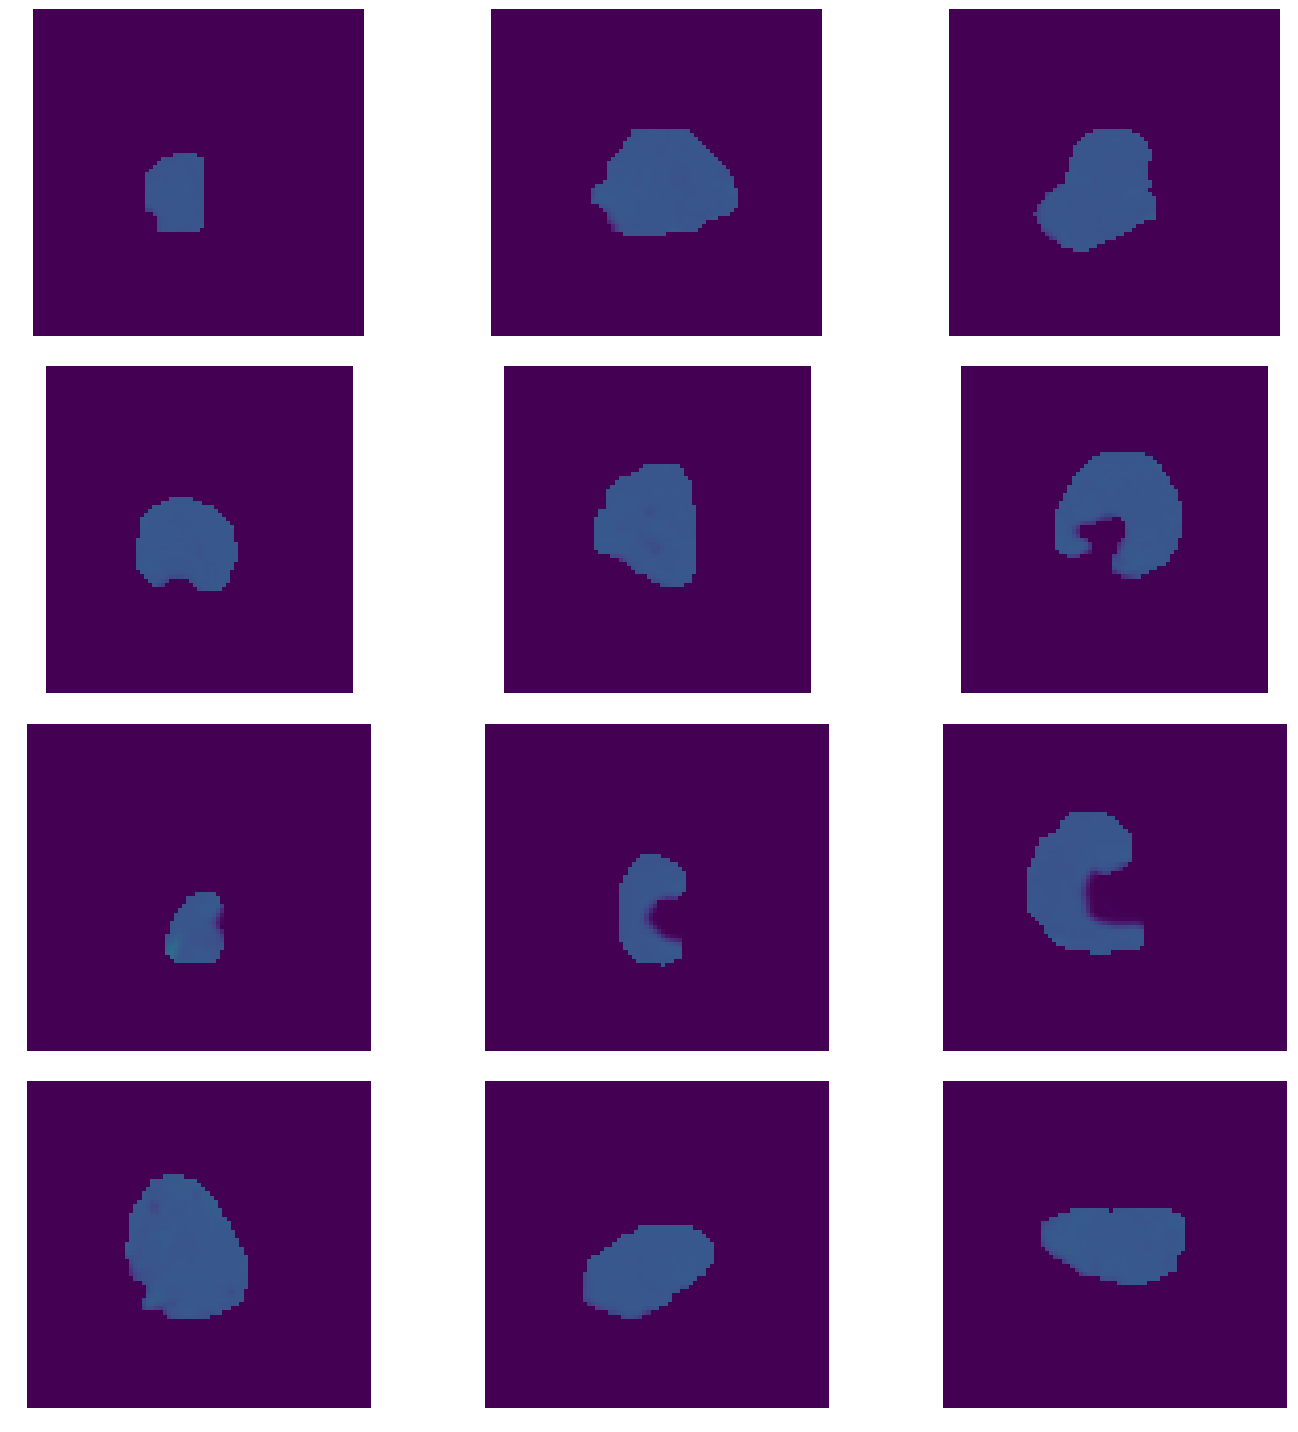

In [30]:
# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.

# Selected slices from the four patients with max(I) > 3000.

images_to_plot = [
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P002CT.nrrd'][:, :, 21],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P002CT.nrrd'][:, :, 26],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P002CT.nrrd'][:, :, 32],
    
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P077CT.nrrd'][:, :, 25],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P077CT.nrrd'][:, :, 35],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P077CT.nrrd'][:, :, 45],
    
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P130CT.nrrd'][:, :, 25],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P130CT.nrrd'][:, :, 37],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P130CT.nrrd'][:, :, 55],
    
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P182CT.nrrd'][:, :, 31],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P182CT.nrrd'][:, :, 41],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P182CT.nrrd'][:, :, 51],
]
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
for num, axis in enumerate(axes.ravel()):
    axis.imshow(
        images_to_plot[num], #cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12,
    ),
    #axis.set_title(titles[num])
    axis.axis('off')   
#plt.subplots_adjust(wspace=0, hspace=0.2)
plt.tight_layout()

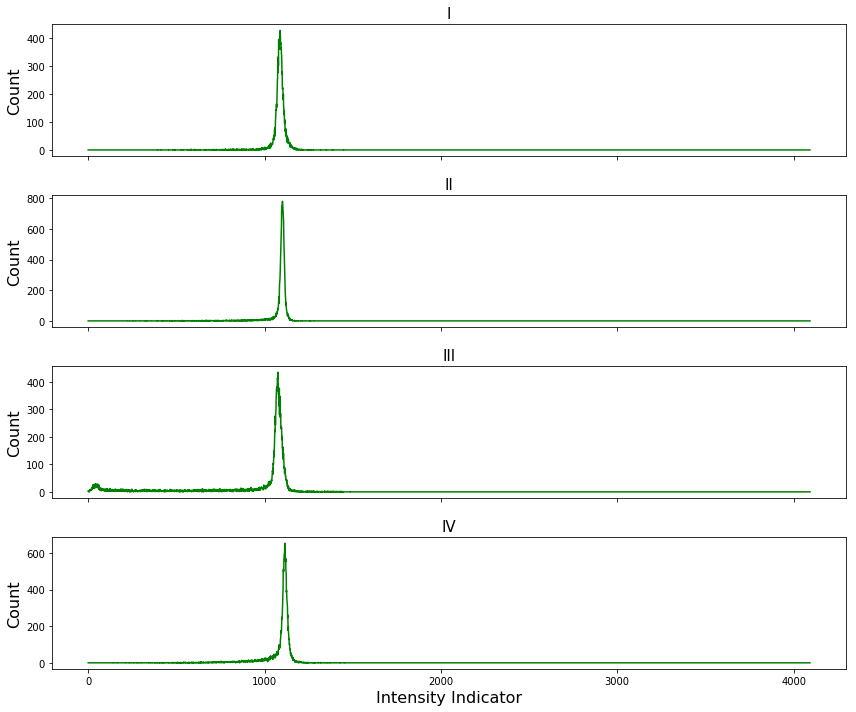

In [31]:
# Observations:
# * Distogram resembles dirac delta function (for small a param, see wiki).

imgs = [
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P002CT.nrrd'],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P077CT.nrrd'],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P130CT.nrrd'],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P182CT.nrrd'],
]
# Try bins: 32, 64, 128 as in feature extraction.
fig, axes = plt.subplots(
    nrows=len(imgs), 
    figsize=(12, 10), 
    sharex=True
)
titles = ['I', 'II', 'III', 'IV']
for num, axis in enumerate(axes.ravel()):
    hist, _ = np.histogram(np.squeeze(imgs[num].ravel()), bins=np.linspace(0, 2**12, 2**12))
    # NOTE: Skip background voxels.
    hist = hist[1:]
    axes[num].set_title(titles[num], fontsize=15)
    axes[num].plot(np.arange(np.size(hist)), np.squeeze(hist))
    axes[num].set_ylabel('Count', fontsize=16)
    
plt.xlabel('Intensity Indicator', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# PET Image & Tumor Graylevel Statistics

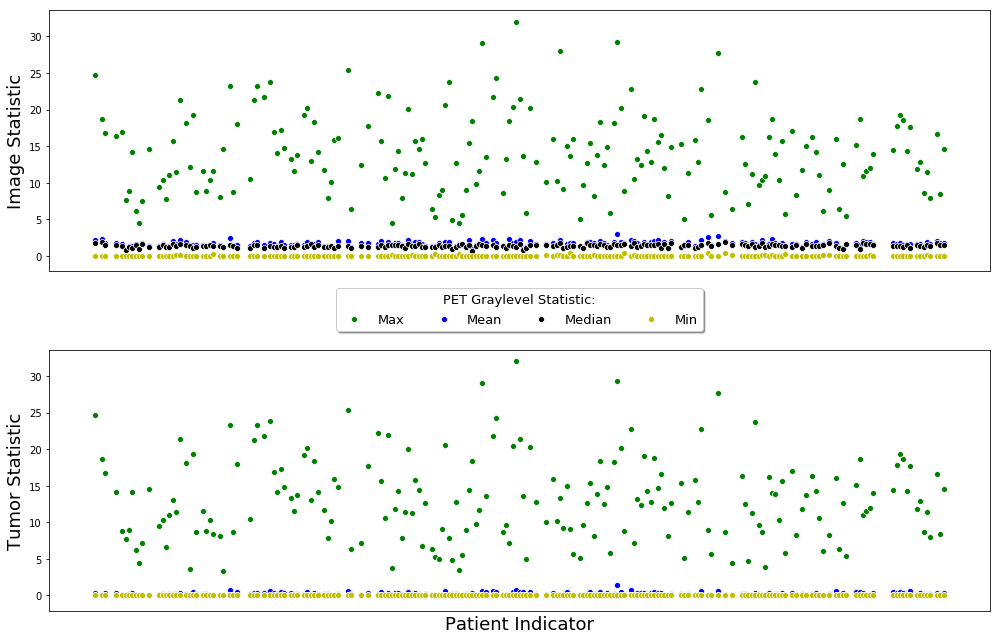

In [32]:
# Plot CT image and tumor GL stats.
#from matplotlib import rcParams, cycler

#colours = sns.diverging_palette(255, 133, l=60, n=4, center="dark")
#rcParams['axes.prop_cycle'] = cycler(color=colours)

fig, (image_axis, cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Max', 'Mean', 'Median', 'Min']
for num, (pet_cropped_row_label, pet_row_label) in enumerate(zip(df_pet_cropped_ad_stats.T, df_pet_ad_stats.T)):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_ad_stats.columns.values), 
        y=np.squeeze(df_pet_ad_stats.loc[pet_row_label, :].values),
        ax=image_axis,
    )
    # Plot tupr stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_cropped_ad_stats.columns.values), 
        y=np.squeeze(df_pet_cropped_ad_stats.loc[pet_cropped_row_label, :].values),
        ax=cropped_axis,
        label=labels[num]
    )
cropped_axis.legend(
    title='PET Graylevel Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
image_axis.set_ylabel('Image Statistic', fontsize=18)
cropped_axis.set_ylabel('Tumor Statistic', fontsize=18)
plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './../../../figures/pet_gl_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Compare CT histogram characteristics

In [33]:
def hist_statistics(image, kind='percentile'):
        
    # Remove zeros from the image since it distrupts 
    # percentile statistics.
    _tmp = image[image != 0].ravel()
    
    if kind == 'percentile':
        image
        return {
            'percentile_95': np.percentile(_tmp, 95),
            'percentile_90': np.percentile(_tmp, 90),
            'percentile_80': np.percentile(_tmp, 80),
            'percentile_70': np.percentile(_tmp, 70),
            'percentile_60': np.percentile(_tmp, 60)
        }
    else:
        return {
            'kurtosis': stats.kurtosis(_tmp),
            'skew': stats.skew(_tmp),
        }

In [34]:
# Histogram statistics on tumor (not cropped) images.
ct_cropped_ad_hist_stats, pet_cropped_ad_hist_stats = {}, {}
for num, (pet_image, ct_image) in enumerate(zip(pet_cropped_ad.values(), ct_cropped_ad.values())):
    
    pet_cropped_ad_hist_stats[num] = hist_statistics(pet_image)
    ct_cropped_ad_hist_stats[num] = hist_statistics(ct_image)

# Sanity check: Adjusting to Python counting logic.
assert num == np.size(patient_id) - 1

df_ct_cropped_ad_hist_stats = pd.DataFrame(ct_cropped_ad_hist_stats)
df_pet_cropped_ad_hist_stats = pd.DataFrame(pet_cropped_ad_hist_stats)

df_ct_cropped_ad_hist_stats.columns = patient_id
df_pet_cropped_ad_hist_stats.columns = patient_id

No handles with labels found to put in legend.


"\nplt.savefig(\n    './../../../figures/ct_gl_stats.png',\n    bbox_inches='tight',\n    transparent=True,\n    dpi=100, \n)"

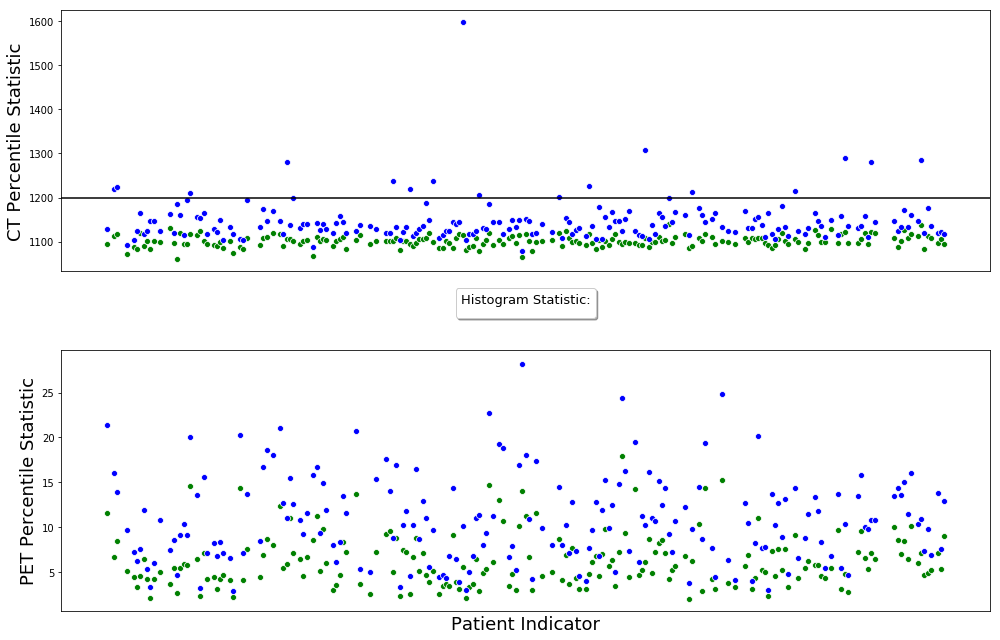

In [36]:
# A percentile (or a centile) is a measure used in statistics indicating the value below which a 
# given percentage of observations in a group of observations falls. For example, the 20th percentile 
# is the value (or score) below which 20% of the observations may be found.  
rcParams['axes.prop_cycle'] = cycler(color=['g', 'b', 'r', 'y', 'm', 'k'])

# Plot CT image and tumor GL histogram stats. 

# Observations: 
# * One patient distriguished by large 95th percentile. Image stack contains much straking artifacts.

fig, (ct_axis, pet_axis) = plt.subplots(nrows=2, sharex=True, figsize=(14, 9))
labels = df_ct_cropped_ad_hist_stats.index
labels = ['60th percentile', '95th percentile']
for num, (ct_row_label, pet_row_label) in enumerate(zip(df_ct_cropped_ad_hist_stats.T, df_pet_cropped_ad_hist_stats.T)):
    sns.scatterplot(
        x=np.squeeze(df_ct_cropped_ad_hist_stats.columns.values), 
        y=np.squeeze(df_ct_cropped_ad_hist_stats.loc[ct_row_label].values),
        ax=ct_axis,
    )
    sns.scatterplot(
        x=np.squeeze(df_pet_cropped_ad_hist_stats.columns.values), 
        y=np.squeeze(df_pet_cropped_ad_hist_stats.loc[pet_row_label].values),
        ax=pet_axis,
        #label=labels[num]
    )

pet_axis.legend(
    title='Histogram Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=6, 
    fancybox=True, 
    shadow=True
)
ct_axis.set_ylabel('CT Percentile Statistic', fontsize=18)
ct_axis.axhline(y=1200, c='k')
pet_axis.set_ylabel('PET Percentile Statistic', fontsize=18)
plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

"""
plt.savefig(
    './../../../figures/ct_gl_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)"""

In [26]:
df_ct_cropped_ad_hist_stats.loc['percentile_95'].max()
# 109
#df_ct_cropped_ad_hist_stats.columns[df_ct_cropped_ad_hist_stats.loc['percentile_95'] == df_ct_cropped_ad_hist_stats.loc['percentile_95'].max()]

1597.4030441748673

In [27]:
df_ct_cropped_ad_hist_stats.loc['percentile_95', 109]

1597.4030441748673

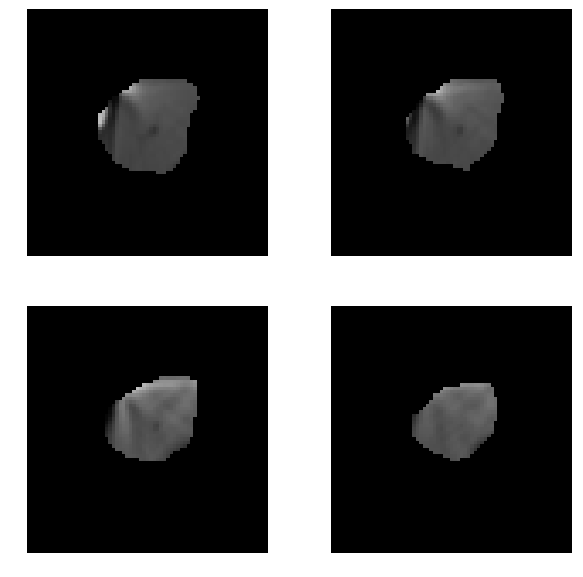

In [28]:
# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.

# Plotting patient with largest 95th percentile.
images_to_plot = [
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 45],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 46],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 48],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 50]
]

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(10, 10)
)
for num, axis in enumerate(axes.ravel()):
    axis.imshow(
        images_to_plot[num], 
        cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12
    )
    axis.axis('off')

In [29]:
# Histogram statistics on tumor (not cropped) images.
ct_cropped_ad_hist_stats2, pet_cropped_ad_hist_stats2 = {}, {}
for num, (pet_image, ct_image) in enumerate(zip(pet_cropped_ad.values(), ct_cropped_ad.values())):
    
    pet_cropped_ad_hist_stats2[num] = hist_statistics(pet_image, kind=None)
    ct_cropped_ad_hist_stats2[num] = hist_statistics(ct_image, kind=None)

# Sanity check: Adjusting to Python counting logic.
assert num == np.size(patient_id) - 1

df_ct_cropped_ad_hist_stats2 = pd.DataFrame(ct_cropped_ad_hist_stats2)
df_pet_cropped_ad_hist_stats2 = pd.DataFrame(pet_cropped_ad_hist_stats2)

df_ct_cropped_ad_hist_stats2.columns = patient_id
df_pet_cropped_ad_hist_stats2.columns = patient_id

"\nplt.savefig(\n    './../../../figures/ct_gl_stats.png',\n    bbox_inches='tight',\n    transparent=True,\n    dpi=100, \n)"

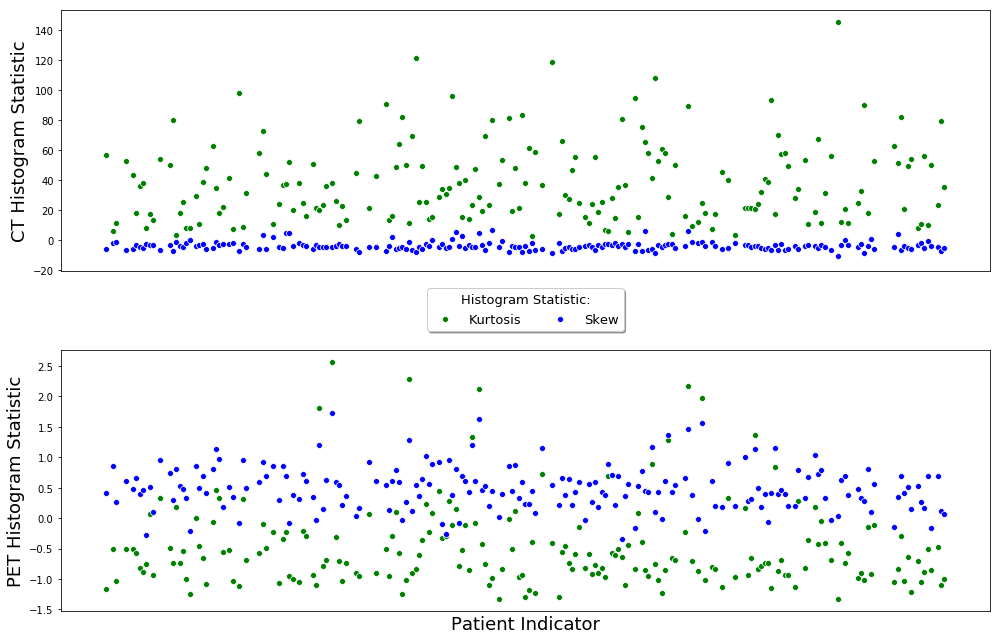

In [30]:
#rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])

# Plot CT image and tumor GL histogram stats. 

# Observations: 
fig, (ct_axis, pet_axis) = plt.subplots(nrows=2, sharex=True, figsize=(14, 9))
labels = df_ct_cropped_ad_hist_stats.index
labels = ['Kurtosis', 'Skew']
for num, (ct_row_label, pet_row_label) in enumerate(zip(df_ct_cropped_ad_hist_stats2.T, df_pet_cropped_ad_hist_stats2.T)):
    sns.scatterplot(
        x=np.squeeze(df_ct_cropped_ad_hist_stats2.columns.values), 
        y=np.squeeze(df_ct_cropped_ad_hist_stats2.loc[ct_row_label].values),
        ax=ct_axis,
    )
    sns.scatterplot(
        x=np.squeeze(df_pet_cropped_ad_hist_stats2.columns.values), 
        y=np.squeeze(df_pet_cropped_ad_hist_stats2.loc[pet_row_label].values),
        ax=pet_axis,
        label=labels[num]
    )

pet_axis.legend(
    title='Histogram Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=6, 
    fancybox=True, 
    shadow=True
)
ct_axis.set_ylabel('CT Histogram Statistic', fontsize=18)
pet_axis.set_ylabel('PET Histogram Statistic', fontsize=18)
plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
"""
plt.savefig(
    './../../../figures/ct_gl_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)"""

# Kolmogorov–Smirnov test

In [ ]:
# NOTE: Possible to cluster all patients with artifacts?

"""
# TODO: Redo test after artifact handling to see if more image distributions seems to originate 
# from the same population.

ct_ks_stat_mat = np.zeros((len(ct_cropped_ad.keys()), len(ct_cropped_ad.keys())), dtype=float)
ct_ks_pvalue_mat = np.zeros((len(ct_cropped_ad.keys()), len(ct_cropped_ad.keys())), dtype=float)

for ref_num, ref_image in enumerate(ct_cropped_ad.values()):
    for sample_num, sample_image in enumerate(ct_cropped_ad.values()):
        ref_hist = np.trim_zeros(ref_image.ravel())
        sample_hist = np.trim_zeros(sample_image.ravel())
        ks_stat, p_value = stats.ks_2samp(ref_hist, sample_hist)
        ct_ks_stat_mat[ref_num, sample_num] = ks_stat
        ct_ks_pvalue_mat[ref_num, sample_num] = p_value
    print('ref num complete', ref_num)
    
"""

In [ ]:
#np.save('./ct_ad_ks_test_stats.npy', ct_ks_stat_mat)
#np.save('./ct_ad_ks_test_pvalues.npy', ct_ks_pvalue_mat)

In [31]:
ct_ad_ks_test_stats = np.load('ct_ad_ks_test_stats.npy')
ct_ad_ks_test_pvalues = np.load('ct_ad_ks_test_pvalues.npy')

In [32]:
ct_ad_ks_test_stats.shape

(195, 195)

<Figure size 576x576 with 0 Axes>

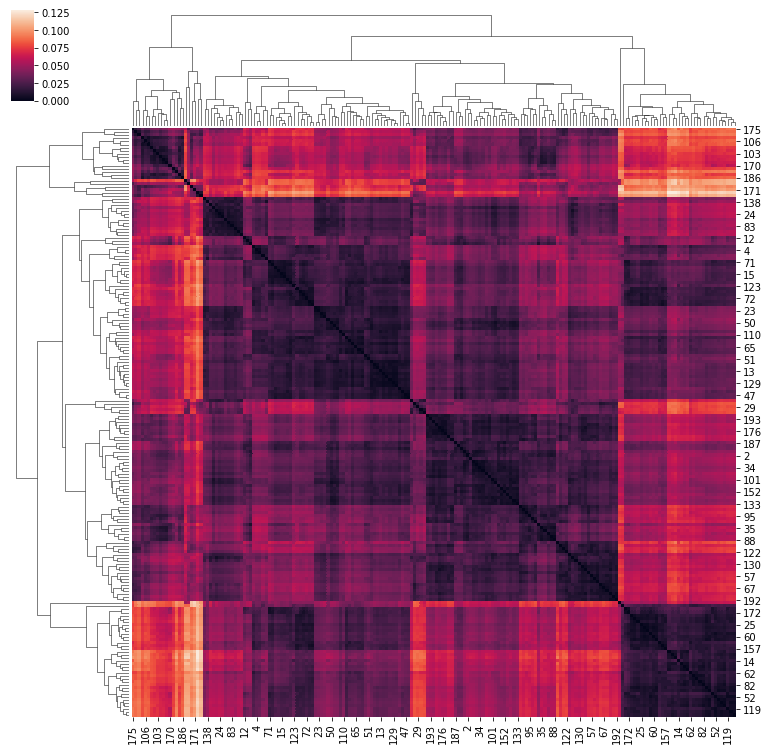

In [33]:
# H0: Two independent samples are drawn from the same continuous distribution.
# If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis 
# that the distributions of the two samples are the same.

# See: https://towardsdatascience.com/kolmogorov-smirnov-test-84c92fb4158d
mat = ct_ad_ks_test_stats
method = 'average'

row_linkage = hierarchy.linkage(
    distance.pdist(mat), method=method
)
col_linkage = hierarchy.linkage(
    distance.pdist(np.transpose(mat)), method=method
)
#cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)

# Array is symmetric and therefore row_linkage and col_linkage will be identical.
plt.figure(figsize=(8, 8))
sns.clustermap(
    mat, 
    row_linkage=row_linkage, 
    col_linkage=col_linkage, 
    method=method,
    figsize=(13, 13), 
    
)

In [34]:
# See: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Selecting-a-Distance-Cut-Off-aka-Determining-the-Number-of-Clusters
def fancy_dendrogram(*args, **kwargs):
    
    max_d = kwargs.pop('max_d', None)
    
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
        
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        #plt.title('Hierarchical Clustering Dendrogram (truncated)')
        #plt.xlabel('sample index or (cluster size)')
        #plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    
    return ddata

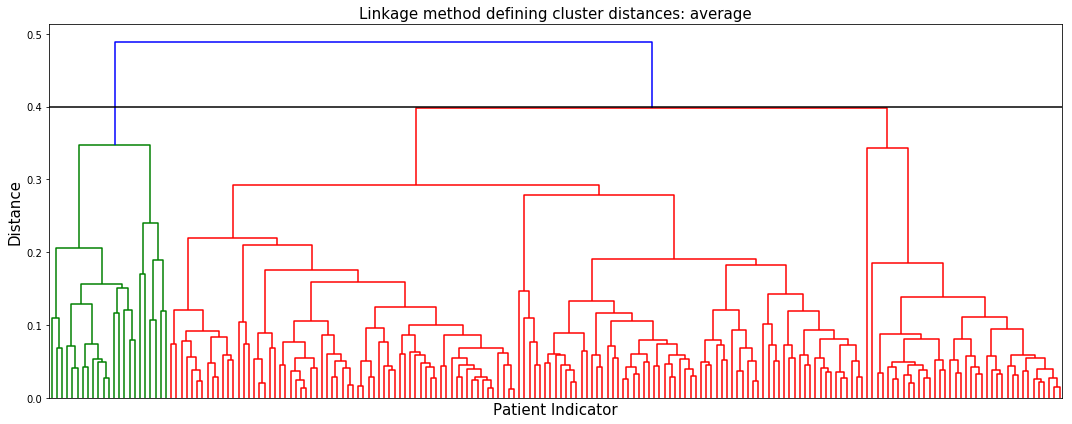

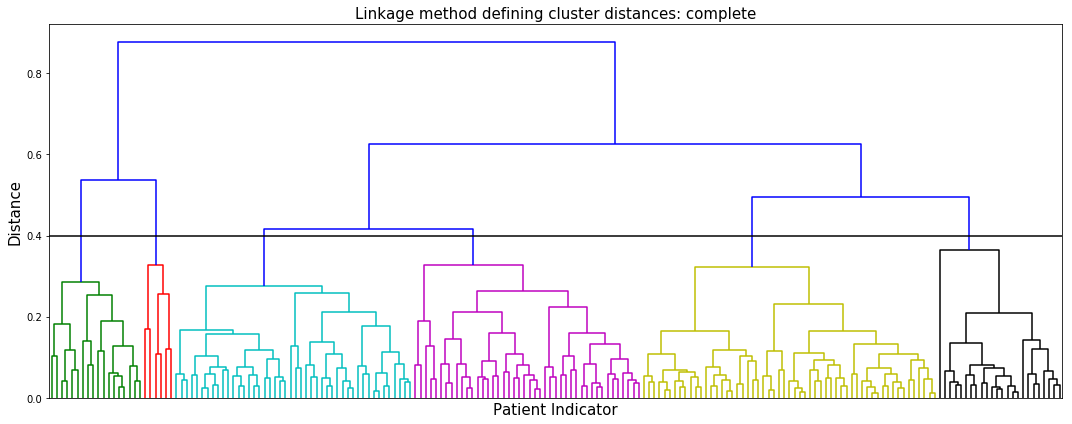

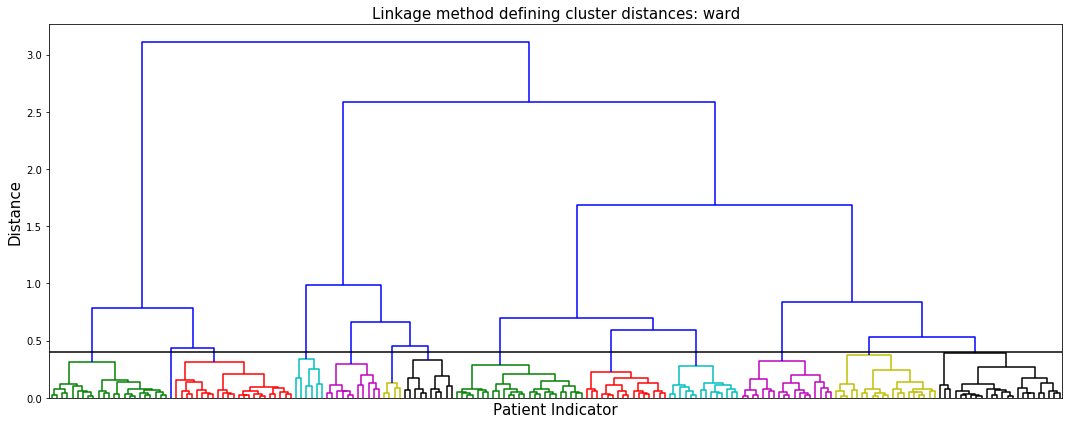

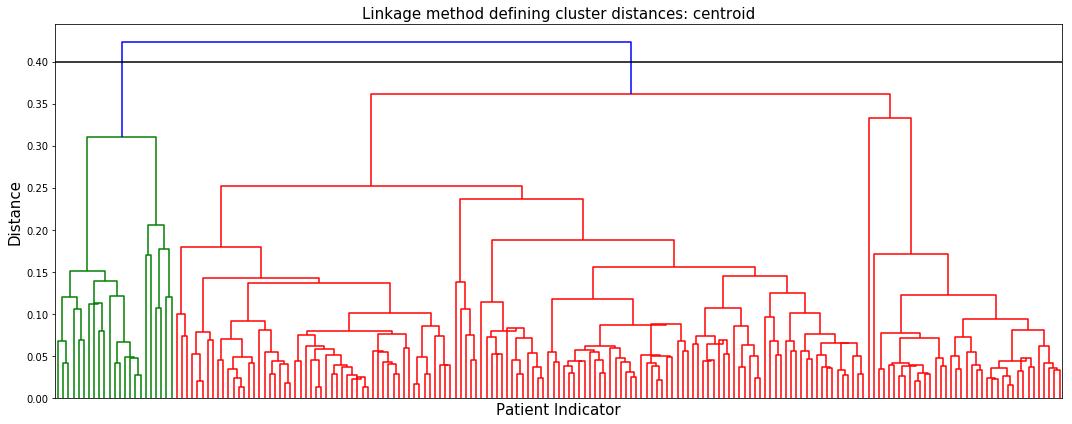

In [35]:
mat = ct_ad_ks_test_stats
# A huge jump in distance may be used to argue a certain number of clusters. 
max_dist = 0.4

# Suggests between 

methods = [
    'average', 'complete', 'ward', 'centroid', 
]
for method in methods:

    plt.figure(figsize=(15, 6))
    plt.title(f'Linkage method defining cluster distances: {method}', fontsize=15)
    plt.xlabel('Patient Indicator', fontsize=15)
    plt.ylabel('Distance', fontsize=15)

    col_linkage = hierarchy.linkage(distance.pdist(mat), method=method)
    
    output = fancy_dendrogram(
        col_linkage,
        leaf_rotation=90.0,  
        leaf_font_size=8.0, 
        annotate_above=10,
        max_d=max_dist,
    )
    plt.xticks([], [])
    plt.tight_layout()

In [36]:
# P-values to determine samples originating from different distributions:
# If p > alpha => samples come from same population.
np.sum(ct_ad_ks_test_pvalues > 0.05), np.sum(ct_ad_ks_test_pvalues < 0.05)

(431, 37594)

In [37]:
np.sum(ct_ad_ks_test_pvalues > 0.05) / (195 * 195) * 100

1.1334648257725182

In [38]:
np.random.seed(2019)

# Select samples from same population.
rows, cols = np.squeeze(np.where(ct_ad_ks_test_pvalues > 0.05))
# Randomly select samples from particular rows.
row_samples = np.random.choice(rows, size=4)
# Randomly select samples from particular columns constrained to match row samples.
col_samples = cols[np.random.choice(np.squeeze(np.where(np.isin(rows, row_samples))), size=3)]

paths_a = np.array(list(ct_cropped_ad.keys()))[row_samples]
paths_b = np.array(list(ct_cropped_ad.keys()))[col_samples]
paths_a, paths_b

(array(['./../../../data_source/images/ct_nrrd/P037CT.nrrd',
        './../../../data_source/images/ct_nrrd/P210CT.nrrd',
        './../../../data_source/images/ct_nrrd/P099CT.nrrd',
        './../../../data_source/images/ct_nrrd/P172CT.nrrd'], dtype='<U49'),
 array(['./../../../data_source/images/ct_nrrd/P148CT.nrrd',
        './../../../data_source/images/ct_nrrd/P136CT.nrrd',
        './../../../data_source/images/ct_nrrd/P148CT.nrrd'], dtype='<U49'))

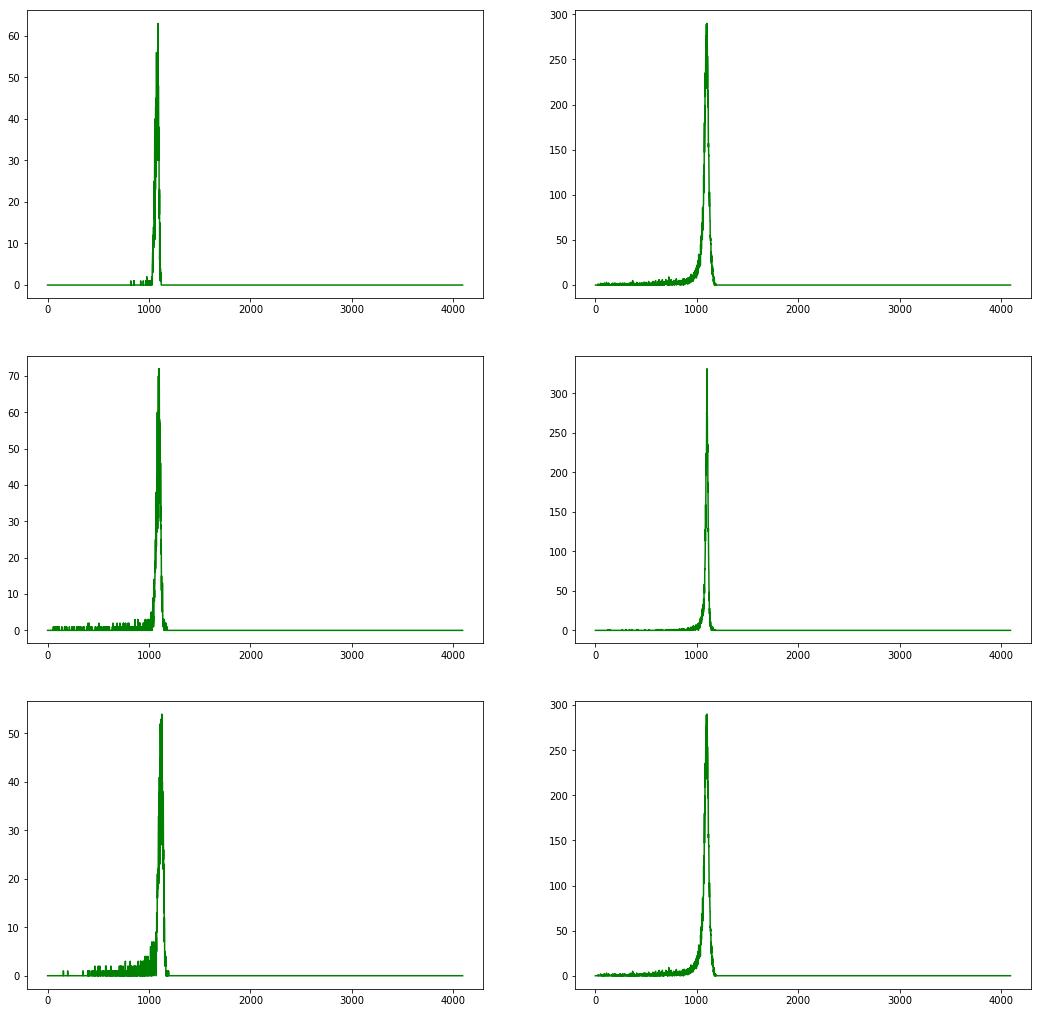

In [39]:
# Plot similar distributions (by p-values). Row A resembles row B.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for num, (path_a, path_b) in enumerate(zip(paths_a, paths_b)):
    img_a = ct_cropped_ad[path_a]
    img_b = ct_cropped_ad[path_b]
    
    hist_a, _ = np.histogram(np.squeeze(img_a.ravel()), bins=np.linspace(0, 2**12, 2**12))
    hist_b, _ = np.histogram(np.squeeze(img_b.ravel()), bins=np.linspace(0, 2**12, 2**12))
    
    # NOTE: Skip background voxels.
    hist_a = hist_a[1:]
    hist_b = hist_b[1:]
    
    axes[num, 0].plot(np.arange(np.size(hist_a)), np.squeeze(hist_a))
    axes[num, 1].plot(np.arange(np.size(hist_b)), np.squeeze(hist_b))
    #axes[num, 0].set_ylabel('Count', fontsize=16)
    #axes[num, 1].set_ylabel('Count', fontsize=16)

In [40]:
np.random.seed(2019)

# Select samples from same population.
rows, cols = np.squeeze(np.where(ct_ad_ks_test_pvalues <= 0.05))
# Randomly select samples from particular rows.
row_samples = np.random.choice(rows, size=3)
# Randomly select samples from particular columns constrained to match row samples.
col_samples = cols[np.random.choice(np.squeeze(np.where(np.isin(rows, row_samples))), size=3)]

paths_a = np.array(list(ct_cropped_ad.keys()))[row_samples]
paths_b = np.array(list(ct_cropped_ad.keys()))[col_samples]
paths_a, paths_b

(array(['./../../../data_source/images/ct_nrrd/P180CT.nrrd',
        './../../../data_source/images/ct_nrrd/P090CT.nrrd',
        './../../../data_source/images/ct_nrrd/P217CT.nrrd'], dtype='<U49'),
 array(['./../../../data_source/images/ct_nrrd/P252CT.nrrd',
        './../../../data_source/images/ct_nrrd/P035CT.nrrd',
        './../../../data_source/images/ct_nrrd/P111CT.nrrd'], dtype='<U49'))

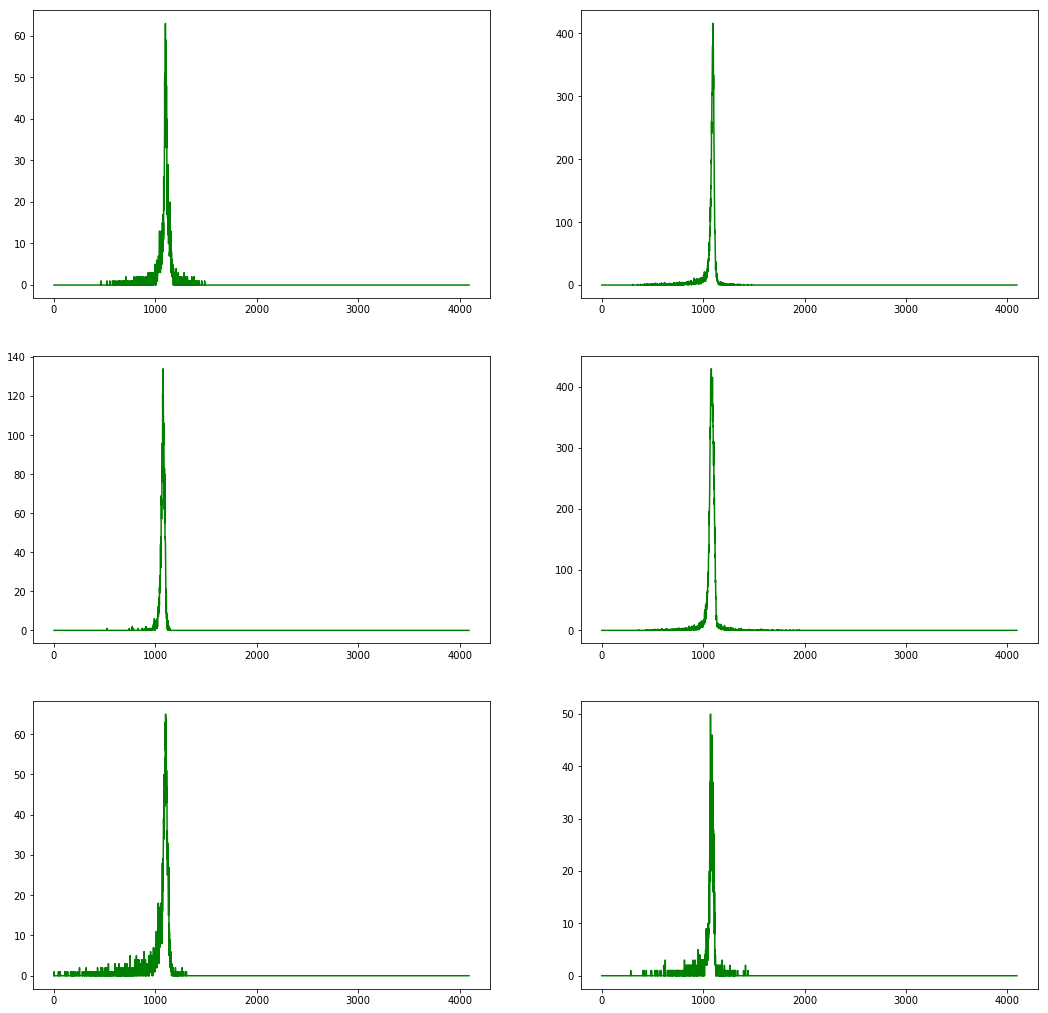

In [41]:
# Plot similar distributions (by p-values). Row A resembles row B.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for num, (path_a, path_b) in enumerate(zip(paths_a, paths_b)):
    img_a = ct_cropped_ad[path_a]
    img_b = ct_cropped_ad[path_b]
    
    hist_a, _ = np.histogram(np.squeeze(img_a.ravel()), bins=np.linspace(0, 2**12, 2**12))
    hist_b, _ = np.histogram(np.squeeze(img_b.ravel()), bins=np.linspace(0, 2**12, 2**12))
    
    # NOTE: Skip background voxels.
    hist_a = hist_a[1:]
    hist_b = hist_b[1:]
    
    axes[num, 0].plot(np.arange(np.size(hist_a)), np.squeeze(hist_a))
    axes[num, 1].plot(np.arange(np.size(hist_b)), np.squeeze(hist_b))
    #axes[num, 0].set_ylabel('Count', fontsize=16)
    #axes[num, 1].set_ylabel('Count', fontsize=16)

In [ ]:
# Sentrum kan velges ut ifra mode (vanligste verdi) i tumor, mens bredden kan velges basert på histogrammene…

# Removing slices influenced by artifacts

In [132]:
def remove_artifact_slices(image, thresh, max_limit=0.75, path_to_log=None):
    
    _image = np.copy(image)
    
    cand_slices = np.where(_image > thresh)[-1]
    affected_slices = []
    # How much of a slice is affected.
    for slice_num in cand_slices:
        num_affected_in_slice = np.sum(image[:, :, slice_num] > thresh)
        num_elems_in_slice = np.size(image[:, :, slice_num])
        print(num_affected_in_slice / num_elems_in_slice * 100)
    
    """
    num_rows, num_cols, num_slices = np.shape(image)
    if num_affected_slices / num_slices > max_limit:
        return None
    else:    
        image_new = np.zeros((num_rows, num_cols, num_slices - num_affected_slices))
        good_slices = np.delete(np.arange(num_slices), affected_slices)
        image_new[:, :, :] = image[:, :, good_slices]    

        return image_new

"""

In [133]:
# A slice was removed if more than ...% of pixels in the slice exceeded a defined threshold value.

# Statistics on complete (not cropped) images.
for num, (pet_image, ct_image) in enumerate(zip(pet_ad.values(), ct_ad.values())):
    image_new = remove_artifact_slices(ct_image, 1500)

0.13223626212165734
0.22039377020276227
0.2057008521892448
0.35263003232441964
0.5730238025271819
0.7052600646488393
0.969732588892154
1.1901263590949163
1.5280634734058183
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
10.123420511313547
12.562444901557448
12.650602409638553
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
0.2057008521892448
0.35263003232441964
0.5730238025271819
0.7052600646488393
0.969732588892154
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
12.562444901557448
12.650602409638553
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.037907

8.360270349691449
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
0.7052600646488393
0.969732588892154
1.1901263590949163
1.5280634734058183
1.7337643255950632
2.0129297678518956
2.248016456068175
2.732882750514252
2.909197766676462
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
0.5730238025271819
0.7052600646488393
0.969732588892154
1.1901263590949163
1.5280634734058183
1.7337643255950632
2.0129297678518956
2.248016456068175
2.732882750514252
2.9091

3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
0.969732588892154
1.1901263590949163
1.5280634734058183
1.7337643255950632
2.0129297678518956
2.248016456068175
2.732882750514252
2.909197766676462
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
1.5280634734058183
1.7337643255950632
2.0129297678518956
2.248016456068175
2.732882750514252
2.909197766676462
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
2.248016456068175
2.732882750514252
2.909197766676462
3.496914487217161
3.761387011460476
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
9.81486923302968
9.565089626799884
8.521892447840141
7.

7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
1.1901263590949163
1.5280634734058183
1.7337643255950632
2.0129297678518956
2.248016456068175
2.732882750514252
2.909197766676462
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.2988539523949

7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
0.7052600646488393
0.969732588892154
1.1901263590949163
1.5280634734058183
1.7337643255950632
2.0129297678518956
2.248016456068175
2.732882750514252
2.909197766676462
3.496914487217161
3.761387011460476
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151

9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
1.5280634734058183
1.7337643255950632
2.0129297678518956
2.248016456068175
2.732882750514252
2.909197766676462
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
7.037907728474875
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499

10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.9

8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.56244490155744

9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.96

8.889215398178079
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
5.8918601234205115
5.950631795474582
6.288568909785483
7.

8.6541287099618
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994

8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.6238612988

11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339

9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
8.962679988245666
8.903908316191595
8.88921539817

8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
10.843373493975903
10.57890096973259
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
10.843373493975903
10.57890096973259
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
10.843373493975903
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
11.298853952394944
10.476050543637966
10.373

3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
12.650602409638553
12.562444901557448
12.650602409638553
12.562444901557448
12.650602409638553
12.562444901557448
12.650602409638553
12.562444901557448
12.650602409638553
12.562444901557448
12.650602409638553
12.562444901557448
12.650602409638553
12.562444901557448
12.650602409638553
12.562444901557448
12.650602409638553
10.123420511313547
12.562444901557448
12.650602409638553
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
8

6.288568909785483
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
9.858947987070232
10.843373493975903
10.57890096973259
2.909197766676462
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.858947987070232
10.843373493975903
10.57890096973259
2.732882750514252
2.909197766676462
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
9.858947987070232
10.843373493975903
10.57890096973259
2.248016456068175
2.732882750514252
2.909197766676462
3.496914487217161
3.761387011460476
4.363796650

10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.843373493975903
10.57890096973259
10.167499265354099
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505

9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.843373493975903
10.57890096973259
10.167499265354099
7.03

11.298853952394944
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.57890096973259
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
8.786364972083456
8.6541287099618
8.889215398178079
9.46223920070

10.505436379665003
11.298853952394944
2.909197766676462
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
2.909197766676462
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
3.7613870

8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
3.496914487217161
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343

8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901

10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
11.29885395

9.623861298853953
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.9782

10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.8892153981

3.761387011460476
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
5.8918601234205115
5.950631795474582
6.288568909785483
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.56508

8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
4.363796650014693
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.5650896

8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.91860123

8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287

10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
4.804584190420218
5.465765501028504
5.8918601234205115
5.950631795474582
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
6.288568909785483
7.6843961210696445
7.978254481339994
7.6843961210696445
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
7.978254481339994
7.6843961210696445
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
10.431971789597414


9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
7.6843961210696445
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493

10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.5650896267998

9.888333823097268
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
0.19100793417572728
0.2057008521892448
0.22039377020276227
0.19100793417572728
0.2057008521892448
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.858947987070232
10.843373493975903
10.57890096973259
9.81486923302968
9.785483397002645


9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
12.650602409638553
10.43

10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.81486923302968
9.565089626799884
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337


10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268

9.623861298853953
9.888333823097268
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.889215398178079
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.81486923302968
9.565089626799884
5.950631795474582
8.786364972083456
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.565089626799884
8.521892447840141
8.6541287099618
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
9.81486923302968
9.565089626799884
8.

8.903908316191595
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
5.465765501028504
5.8918601234205115
5.950631795474582
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.88833382309

7.978254481339994
9.947105495151337
10.123420511313547
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
8.521892447840141
7.978254481339994
9.947105495151337
10.123420511313547
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
7.978254481339994
9.888333823097268
9.81486923302968
9.565089626799884
7.978254481339994
7.6843961210696445
9.81486923302968
9.565089626799884
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
10.123420511313547
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
10.505436379665003
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
10.505436379665003
11.298853952394944
10.57890096973259
10.1674992653

9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
9.565089626799884
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
9.81486923302968
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.888333823097268
0.2057008521892448
0.35263003232441964
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.65060

9.785483397002645
8.521892447840141
7.978254481339994
9.462239200705259
10.505436379665003
11.298853952394944
9.947105495151337
10.123420511313547
12.562444901557448
9.785483397002645
9.623861298853953
9.888333823097268
8.521892447840141
7.978254481339994
7.978254481339994
9.947105495151337
10.123420511313547
9.623861298853953
9.888333823097268
9.623861298853953
9.888333823097268
9.81486923302968
9.888333823097268
9.81486923302968
9.565089626799884
10.476050543637966
10.373200117543343
9.785483397002645
9.888333823097268
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
9.81486923302968
9.565089626799884
8.521892447840141
7.978254481339994
11.298853952394944
10.476050543637966
10.373200117543343
9.81486923302968
9.565089626799884
8.521892447840141
9.81486923302968
9.565089626799884
8.889215398178079
9.462239200705259
10.476050543637966
10.373200117543343
9.947105495151337
9.81486923302968
9.

10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
10.167499265354099
9.858947987070232
9.81486923302968
9.785483397002645
9.623861298853953
9.947105495151337
10.123420511313547
12.56244

11.298853952394944
10.476050543637966
10.373200117543343
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
9.81486923302968
9.785483397002645
0.13223626212165734
8.889215398178079
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.81486923302968
9.462239200705259
10.505436379665003
11.298853952394944
10.476050543637966
10.373200117543343
9.947105495

0.19100793417572728
0.2057008521892448
0.22039377020276227
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
8.786364972083456
0.19100793417572728
0.13223626212165734
0.22039377020276227
6.288568909785483
7.037907728474875
7.434616514839846
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
0.19100793417572728
3.496914487217161
3.761387011460476
5.8918601234205115
5.950631795474582
8.360270349691449
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
0.19100793417572728
2.909197766676462
3.496914487217161
3.761387011460476
8.712900382015869
8.918601234205113
8.962679988245666
8.903908316191595
8.889215398178079
3.496914487217161
3.761387011460476
8.712900382015869
8.918601234205113
8.962679988245666
8.918601234205113
5.8918601234205115
5.8918601234205115
8.712900382015869
8.918601234205113
8.96267998

10.57890096973259
10.167499265354099
9.623861298853953
9.888333823097268
7.978254481339994
7.978254481339994
7.6843961210696445
10.505436379665003
11.298853952394944
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
9.888333823097268
7.6843961210696445
9.462239200705259
10.505436379665003
11.298853952394944
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
9.462239200705259
10.505436379665003
11.298853952394944
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
9.565089626799884
8.521892447840141
9.462239200705259
10.505436379665003
11.298853952394944
9.947105495151337
10.123420511313547
12.562444901557448
12.650602409638553
10.431971789597414
9.858947987070232
10.843373493975903
10.57890096973259
9.565089626799884
8.521892447840141
7.97825448133999

5.615942028985507
5.661231884057971
6.702898550724639
6.929347826086957
6.7934782608695645
6.023550724637681
5.52536231884058
4.936594202898551
5.004528985507246
5.570652173913043
6.61231884057971
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
6.929347826086957
8.084239130434783
8.831521739130435
6.9519927536231885
6.7934782608695645
6.023550724637681
5.52536231884058
4.936594202898551
5.004528985507246
5.57065

15.39855072463768
14.492753623188406
13.043478260869565
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
5.615942028985507
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.65670

7.518115942028985
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
6.929347826086957
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
13.043478260869565
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
13.043478260869565
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.7309782608695

15.39855072463768
24.139492753623188
27.264492753623188
25.656702898550726
16.485507246376812
15.39855072463768
24.139492753623188
27.264492753623188
25.656702898550726
24.139492753623188
27.264492753623188
25.656702898550726
27.264492753623188
16.485507246376812
16.485507246376812
19.950181159420293
24.139492753623188
19.950181159420293
24.139492753623188
27.264492753623188
19.950181159420293
24.139492753623188
27.264492753623188
16.553442028985508
16.485507246376812
19.950181159420293
24.139492753623188
27.264492753623188
15.557065217391305
16.553442028985508
16.485507246376812
19.950181159420293
24.139492753623188
15.557065217391305
16.553442028985508
16.485507246376812
19.950181159420293
24.139492753623188
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
11.073369565217392
19.950181159420293
24.139492753623188
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
11.073369565217392
11.231884057971014
19.950181159420293
24.1394927536231

14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
6.023550724637681
5.52536231884058
4.936594202898551
5.004528985507246
5.570652173913043
6.61231884057971
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
5.52536231884058
4.936594202898551
5.004528985507246
5.570652173913043
6.61231884057971
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.

19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
4.936594202898551
5.004528985507246
5.570652173913043
6.61231884057971
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
25.656702898550726
18.795289855072465
25.656702898550726
18.795289855072465
25.656702898550726
18.795289855072465
25.656702898550726
25.656702898550726
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
17.4818

5.570652173913043
6.61231884057971
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
25.656702898550726
18.795289855072465
15.443840579710145
18.795289855072465
15.443840579710145
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
19.950181159420293
24.139492753623188
27.264492753623188


18.795289855072465
15.443840579710145
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855

25.656702898550726
18.795289855072465
15.443840579710145
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
27.264492753623188
25.656702898550726
18.795289855072465
27.264492753623188
25.656702898550726
18.795289855072465
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
11.254528985507246
12.296195652173914
13.043478260869565
27.264492753623188
25.656702898550726
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
6.929347826086957
8.084239130434783
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
11.254528985507246
12.296195652173914
27.264492753623188
25.656702898550726
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
6.929347826086957
8.084239130434783
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
27.264492753623188
6.929347826086957
8.0842391

17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
11.345108695652174
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
8.084239130434783
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
11.254528985507246
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
11.231884057971014
11.345108695652174
11.254528985507246
12.296195652173914
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
12.296195652173914
13.043478260869565
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
14.990942028985508
15.217391304347828
15.602

19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
11.254528985507246
12.296195652173914
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
11.254528985507246
12.296195652173914
13.043478260869565
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
13.949275362318842
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
14.990942028985508
15.217391304347828
15.602

15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
4.936594202898551
5.004528985507246
5.570652173913043
6.61231884057971
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
4.936594202898551
5.004528985507246
5.570652173913043
6.61231884057971
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.6023550724637

14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
6.929347826086957
8.084239130434783
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
11.254528985507246
12.296195652173914
13.043478260869565
13.949275362318842
14.945652173913043
16.485507246376812
6.61231884057971
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
7.5181159420

27.264492753623188
25.656702898550726
24.139492753623188
27.264492753623188
25.656702898550726
24.139492753623188
27.264492753623188
25.656702898550726
24.139492753623188
27.264492753623188
25.656702898550726
24.139492753623188
27.264492753623188
24.139492753623188
27.264492753623188
24.139492753623188
27.264492753623188
11.073369565217392
11.231884057971014
27.264492753623188
11.073369565217392
11.231884057971014
11.345108695652174
11.254528985507246
27.264492753623188
11.073369565217392
11.231884057971014
11.345108695652174
27.264492753623188
25.656702898550726
27.264492753623188
25.656702898550726
27.264492753623188
25.656702898550726
27.264492753623188
25.656702898550726
27.264492753623188
25.656702898550726
27.264492753623188
25.656702898550726
27.264492753623188
25.656702898550726
27.264492753623188
25.656702898550726
25.656702898550726
18.795289855072465
18.795289855072465
18.795289855072465
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
11.2545289855

11.254528985507246
12.296195652173914
13.043478260869565
13.949275362318842
14.945652173913043
16.485507246376812
17.09692028985507
17.34601449275362
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
8.084239130434783
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
11.254528985507246
12.296195652173914
13.043478260869565
13.949275362318842
14.945652173913043
16.485507246376812
17.09692028985507
17.34601449275362
16.893115942028984
17.6856884057971
13.043478260869565
13.949275362318842
14.945652173913043
16.485507246376812
17.09692028985507
17.34601449275362
16.893115942028984
17.6856884057971
17.66304347826087
17.09692028985507
17.34601449275362
16.893115942028984
17.6856884057971
17.66304347826087
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
6.702898550724639
6.929347826086957
8.084239130434783
19.950181159420293

6.929347826086957
8.084239130434783
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
11.254528985507246
12.296195652173914
13.043478260869565
13.949275362318842
14.945652173913043
16.485507246376812
17.09692028985507
6.61231884057971
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
6.929347826086957
8.084239130434783
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
11.254528985507246
12.296195652173914
13.043478260869565
13.949275362318842
14.945652173913043
16.485507246376812
17.09692028985507
17.34601449275362
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
12.296195652173914
13.043478260869565
13.949275362318842
14.945652173913043
16.485507246376812
17.09692028985507
17.34601449275362
16.893115942028984
17.6856884057

27.264492753623188
15.443840579710145
15.557065217391305
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.341485507246377
12

25.656702898550726
24.139492753623188
27.264492753623188
25.656702898550726
24.139492753623188
27.264492753623188
25.656702898550726
24.139492753623188
27.264492753623188
25.656702898550726
5.615942028985507
6.317934782608696
6.9519927536231885
6.974637681159421
24.139492753623188
27.264492753623188
25.656702898550726
5.615942028985507
6.317934782608696
6.9519927536231885
6.974637681159421
6.5896739130434785
24.139492753623188
27.264492753623188
25.656702898550726
5.615942028985507
6.317934782608696
6.9519927536231885
6.974637681159421
6.5896739130434785
24.139492753623188
27.264492753623188
25.656702898550726
5.615942028985507
6.317934782608696
6.9519927536231885
6.974637681159421
6.5896739130434785
24.139492753623188
27.264492753623188
25.656702898550726
5.615942028985507
6.317934782608696
6.9519927536231885
6.974637681159421
6.5896739130434785
27.264492753623188
25.656702898550726
5.615942028985507
6.317934782608696
6.9519927536231885
6.974637681159421
6.5896739130434785
6.340579710

17.09692028985507
17.34601449275362
16.893115942028984
17.6856884057971
17.66304347826087
17.09692028985507
17.34601449275362
16.893115942028984
8.084239130434783
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.341485507246377
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790

10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
6.929347826086957
8.084239130434783
8.831521739130435
11.073369565217392
11.231884057971014
11.345108695652174
11.254528985507246
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507

15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
6.929347826086957
8.084239130434783
8.831521739130435
11.073369565217392
11.231884057971014
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.34148550

18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
6.929347826086957
8.084239130434783
8.51449275362319
9.193840579710146
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.341485507246377
11.8885869

17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
6.929347826086957
8.084239130434783
8.831521739130435
11.073369565217392
11.231884057971014
10.09963768115942
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.4855

15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
11.028079710144928
12.862318840579709
13.586956521739129
14.402173913043478
14.990942028985508
15.217391304347828
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.519021739130435
13.043478260869565
12.341485507246377
11.888586956521738
9.941123188405797
7.518115942028985
6.317934782608696
5.615942028985507
5.661231884057971
6.702898550724639
11.028079710144928
12.862

17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
15.60235507246377
16.644021739130434
17.730978260869566
18.795289855072465
19.2481884057971
17.527173913043477
17.481884057971016
19.950181159420293
24.139492753623188
27.264492753623188
25.656702898550726
18.795289855072465
15.443840579710145
15.443840579710145
15.557065217391305
16.553442028985508
16.485507246376812
15.39855072463768
14.492753623188406
13.790760869565217
13.

KeyboardInterrupt: 

# Windowing

In [ ]:
# Know that most (all) CT intensities > 1300 are caused by artifacts.

# Let window width 0 <= (WW) <= 1400 (defines the range of valid CT intensities). 
# Window centre, the midpoint of the range of the CT numbers displayed, is mode of width.

In [46]:
from scipy.stats import mode
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd


class BasePreprocessor(ABC):

    @abstractmethod
    def __call__(self, images, targets):
        """The function being applied to the input images.
        """
        pass

    @abstractmethod
    def output_channels(self, input_channels):
        """The number of output channels as a function of input channels.
        """
        pass

    @abstractmethod
    def output_targets(self, input_targets):
        """The number of output channels as a function of input channels.
        """
        pass


class Preprocessor(BasePreprocessor):
    """Superclass for all preprocessors. Does nothing.
    """

    def __call__(self, images):
        """The function being applied to the input images.
        """
        return images

    def output_channels(self, input_channels):
        """The number of output channels as a function of input channels.
        """
        return input_channels

    def output_targets(self, input_targets):
        """The number of output channels as a function of input channels.
        """
        return input_targets


class WindowingPreprocessor(Preprocessor):
    """Used to set the dynamic range of an image.
    """

    def __init__(self, window_center, window_width, channel):
        
        self.window_center = window_center
        self.window_width = window_width
        self.channel = channel

    def perform_windowing(self, image):

        image = image - self.window_center
        image[image < -self.window_width / 2] = -self.window_width / 2
        image[image > self.window_width / 2] = self.window_width / 2

        return image

    def __call__(self, images, targets):

        images = images.copy()
        images[:, self.channel] = self.perform_windowing(images[:, self.channel])

        return images, targets


class MultipleWindowsPreprocessor(WindowingPreprocessor):
    """Used to create multiple windows of the same channel.
    """

    def __init__(self, window_centers, window_widths, channel):
        
        self.window_centers = window_centers
        self.window_widths = window_widths
        self.channel = channel

    def generate_all_windows(self, images):
        channel = images[:, self.channel]
        
        new_channels = []
        for window_center, window_width in zip(self.window_centers, self.window_widths):
            self.window_center, self.window_width = window_center, window_width
            new_channel = self.perform_windowing(channel)
            new_channels.append(new_channel)

        return np.stack(new_channels, axis=-1)

    def __call__(self, images, targets):
        new_channels = self.generate_all_windows(images)

        # Replace current CT channel with all windowed versions
        images = np.delete(images, self.channel, axis=-1)
        images = np.concatenate((images, new_channels), axis=-1)
        return images, targets

    def output_channels(self, input_channels):
        return input_channels + len(self.window_widths) - 1


In [ ]:
# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
images_to_plot = [
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 45],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 46],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 48],
    ct_cropped_ad['./../../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 50]
]

fig, axes = plt.subplots(
    nrows=4, ncols=2, figsize=(10, 10)
)
for num, image in enumerate(images_to_plot):
    axes[num, 0].imshow(
        image, 
        cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12
    )
    multi_trans = MultipleWindowsPreprocessor(
        
    )
    axes[num, 1].imshow(
        image, 
        cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12
    )
    #axis.axis('off')

# Structural similarity index

In [ ]:
# NOTE: Determine window size from histogram.
largest_tumor_image = ct_cropped_ad['./../../../data_source/images/ct_nrrd/P114CT.nrrd']
X_dim_size = np.unique(np.where(largest_tumor_image != 0)[0]).size
Y_dim_size = np.unique(np.where(largest_tumor_image != 0)[1]).size
Z_dim_size = np.unique(np.where(largest_tumor_image != 0)[2]).size

X_dim_size, Y_dim_size, Z_dim_size

In [ ]:
# Structural similarity index (SSIM) is used for measuring the similarity between two images. 
ssim_vals = np.zeros((len(ct_cropped_ad.keys()), len(ct_cropped_ad.keys())), dtype=np.float32)
for ref_num, ref_ct_image in enumerate(ct_cropped_ad.values()):
    for sample_num, sample_ct_image in enumerate(ct_cropped_ad.values()):
        # Resize images to largest tumor size and insert image values.
        # See: https://stackoverflow.com/questions/41171034/how-does-the-numpy-resize-and-numpy-reshape-function-works-internally-in-python
        _ref_ct_image = np.resize(ref_ct_image, (X_dim_size, Y_dim_size, Z_dim_size))
        _sample_ct_image = np.resize(sample_ct_image, (X_dim_size, Y_dim_size, Z_dim_size))
        # skimage.measure.compare_ssim
        # http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim

        #ssim_vals[ref_num, sample_num] = 
        #stat, _, _ = compare_ssim(
        #    X=_ref_ct_image, 
        #    Y=_sample_ct_image, 
        #    gaussian_weights=True,
        #    gradient=False,
        #    multichannel=False,
        #   
        #    data_range=np.max(_sample_ct_image) - np.min(_sample_ct_image),
        #    full=False,
        #)

# Clinical variables: HPV status vs. Sex

* Typical that women (not men) recieve HPV vaccine.
* If HPV is predictive: Norwegian gov. intro. free vaccine. 

In [ ]:
DROPPED = [38, 45, 82]

y = pd.read_csv('./../../../data_source/to_analysis/target_dfs.csv', index_col=0)
orig_size = np.size(y)
y.drop(DROPPED, inplace=True)
new_size = np.size(y)
y = np.squeeze(y.values)
# Sanity check.
assert orig_size == new_size + len(DROPPED)

clinical = pd.read_excel('./../../../data_source/tabular/clinical_params.xlsx', index_col=0)
clinical.drop(DROPPED, inplace=True)
clinical.head()

In [ ]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.5)
sns.violinplot(x='Kjønn', y='HPV-status', data=clinical)
plt.xticks([0, 1], ['M', 'F'])
plt.xlabel('Patient Sex')
plt.ylabel('HPV Status')
plt.tight_layout()
plt.savefig(
    './../../../figures/sex_vs_hpv.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Outcome distribution

In [ ]:
sns.set(style='whitegrid')
fig = plt.figure(figsize=(8, 6))
axis = sns.countplot(x=y, saturation=0.85)

plt.ylabel('Count', fontsize=16)
plt.xticks(range(2), ['Progression-Free Survival', 'Relapse'], fontsize=14)

dfs_ratios = [1 - sum(y) / y.size, sum(y) / y.size, ]
for num, patch in enumerate(axis.patches):
    plt.annotate(
        '{:.1f}%'.format(dfs_ratios[num] * 100),
        (patch.get_x() + patch.get_width() / 2.5, patch.get_height() + 1), 
        color='k', fontsize=14
    )
      
plt.tight_layout()
plt.savefig(
    './../../../figures/outcome_distr.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)